# Определение перспективного тарифа для компании «Мегалайн»

В рамках исследования необходимо проанализировать два тарифных плана компании «Мегалайн»: «Смарт» и «Ультра». Коммерческий департамент хочет понять, какой из этих тарифов приносит больше денег, чтобы скорректировать рекламный бюджет.

Наша задача — сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год ежемесячно. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Открытие данных

Импортируем необходимые библиотеки, загрузим таблицы для работы и сохраним их в следующих переменных:
* calls — информация о звонках;
* internet — информация об интернет-сессиях;
* messages — информация о сообщениях;
* users — информация о пользователях; 
* tariffs — информация о тарифах. 

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math 
import warnings 
warnings.filterwarnings('ignore')

In [54]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [55]:
calls.sample(5, random_state=1)

,id,call_date,duration,user_id
26953,1066_374,2018-08-26,0.00,1066
66122,1168_1273,2018-03-28,16.05,1168
67325,1171_350,2018-09-14,6.23,1171
74643,1186_465,2018-09-02,0.79,1186
192311,1472_124,2018-05-04,5.94,1472


In [56]:
internet.sample(5, random_state=1)

,Unnamed: 0,id,mb_used,session_date,user_id
35745,35745,1124_125,122.45,2018-12-03,1124
18383,18383,1064_102,320.60,2018-12-19,1064
59774,59774,1203_22,605.96,2018-06-17,1203
56317,56317,1188_123,781.73,2018-05-08,1188
52231,52231,1176_386,150.98,2018-08-20,1176


In [57]:
messages.sample(5, random_state=1)

,id,message_date,user_id
45696,1197_26,2018-12-31,1197
66091,1282_523,2018-11-30,1282
18743,1082_184,2018-10-18,1082
33759,1146_557,2018-12-22,1146
11403,1048_49,2018-09-27,1048


In [58]:
users.sample(5, random_state=1)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
304,1304,68,NaN,Владимир,Илья,Соловьёв,2018-11-05,ultra
340,1340,50,NaN,Пенза,Тимофей,Алютин,2018-01-30,smart
47,1047,67,NaN,Саратов,Милица,Меркулова,2018-10-29,smart
67,1067,45,NaN,Москва,Юзефа,Абашкина,2018-04-09,smart
479,1479,40,NaN,Хабаровск,Игорь,Богданов,2018-07-03,smart


In [59]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Рассмотрим, какая информация содержится в каждой из таблиц:

Таблица *users* (информация о пользователях):
* user_id — уникальный идентификатор пользователя;
* first_name — имя пользователя;
* last_name — фамилия пользователя;
* age — возраст пользователя (годы);
* reg_date — дата подключения тарифа (день, месяц, год);
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
* city — город проживания пользователя;
* tariff — название тарифного плана.

Таблица *calls* (информация о звонках):
* id — уникальный номер звонка;
* call_date — дата звонка;
* duration — длительность звонка в минутах;
* user_id — идентификатор пользователя, сделавшего звонок.

Таблица *messages* (информация о сообщениях):
* id — уникальный номер сообщения;
* message_date — дата сообщения;
* user_id — идентификатор пользователя, отправившего сообщение.

Таблица *internet* (информация об интернет-сессиях):
* id — уникальный номер сессии;
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
* session_date — дата интернет-сессии;
* user_id — идентификатор пользователя.

Таблица *tariffs* (информация о тарифах):
* tariff_name — название тарифа;
* rub_monthly_fee — ежемесячная абонентская плата в рублях;
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
* messages_included — количество сообщений в месяц, включённых в абонентскую плату;
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

Из таблицы *tariffs* можем описать каждый тарифный план:

Тариф *«Смарт»*:
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15360 Мб (или 15 Гб) интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

Тариф *«Ультра»*:
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30720 Мб (или 30 Гб) интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

Получим общую информацию о таблицах и типах данных методом *info()*:

In [60]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [61]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [62]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [63]:
messages.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [64]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Вывод**

Судя по количеству строк, выбранные 500 пользователей «Мегалайна» чаще звонят (более 200 тысяч записей), реже — заходят в интернет и отправляют сообщения. У нас нет данных о длительности интернет-сессий — только объем трафика, поэтому не можем утверждать, что на телефонные разговоры клиенты тратят больше времени, чем на интернет. 

В таблице с данными о пользователях в строке *churn_date* (дата прекращения пользования тарифом) всего 38 записей, но это означает, что клиент не отказался от услуг компании — то есть на эти пропуски можно не обращать внимание. Также в таблице с информацией о звонках мы заметили строчки с нулевым значением (0,00 минут). Скорее всего, это пропущенные или непринятые звонки. Во всех таблицах столбцы с датами записаны в типе *object*, на этапе обработки данных нам нужно будет привести их к типу *datetime*.

## Предобработка данных

Мы уже установили, что есть столбцы, значения в которых необходимо привести к иному типу данных. Также нам нужно выяснить, есть ли в таблицах ошибки или аномалии.

### Замена типов данных

Мы ранее отмечали, что в столбцах с датами нужно заменить тип данных на *datetime*. Также создадим таблицах с данными о звонках, сообщениях и интернет-трафике новый столбец *month* с указанием номера месяца, потому что нам нужно будет проанализировать ежемесячное поведение клиентов. 

In [65]:
#меняем тип данных в таблице calls, создаем столбец с номером месяца звонка
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
#создадим в calls новый столбец month с номером месяца подключения к тарифу
calls['month'] = calls['call_date'].dt.month

calls[['call_date', 'month']].head(3)

,call_date,month
0,2018-07-25,7
1,2018-08-17,8
2,2018-06-11,6


In [66]:
#меняем тип данных в internet, создаем столбец с номером месяца интернет-сессии
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
#новый столбец с номером месяца
internet['month'] = internet['session_date'].dt.month

internet[['session_date', 'month']].head(3)

,session_date,month
0,2018-11-25,11
1,2018-09-07,9
2,2018-06-25,6


In [67]:
#меняем тип данных в messages, создаем столбец с номером месяца, когда было отправлено сообщение
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
#новый столбец с номером месяца
messages['month'] = messages['message_date'].dt.month

messages[['message_date', 'month']].head(3)

,message_date,month
0,2018-06-27,6
1,2018-10-08,10
2,2018-08-04,8


**Вывод**

Заменили типы данных в датах и создали в каждой таблице столбец с указанием номера месяца — он нам понадобится для анализа поведения пользователей.

### Исправление ошибок в данных

Нам известно, что компания «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Мы можем округлить в большую сторону столбцы с длительностью звонков и с объемом потраченного за сессию интернет-трафика. 

In [68]:
#округлим значения при помощи метода ceil библиотеки numpy - он округляет числа в бОльшую сторону
#затем приведем эти данные к типу int
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
calls[['user_id', 'duration']].sample(5, random_state=1)

,user_id,duration
26953,1066,0
66122,1168,17
67325,1171,7
74643,1186,1
192311,1472,6


In [69]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')
internet[['user_id', 'mb_used']].sample(5, random_state=1)

,user_id,mb_used
35745,1124,123
18383,1064,321
59774,1203,606
56317,1188,782
52231,1176,151


В таблице с информацией о звонках мы заметили строчки со значением 0 минут. Посчитаем, сколько всего таких звонков:

In [70]:
#методом loc выявим строки со значением = 0 и посчитаем их количество методом count()
calls.loc[calls['duration'] == 0, ['duration']].count()

duration    39613
dtype: int64

Таких «нулевых» звонков в таблице почти 40 тысяч, они составляют примерно пятую часть всех данных. Ошибки здесь быть не может, вероятно, это пропущенные или непринятые звонки. Округлять их до единицы было бы неправильно. Также у нас нет данных, на основе которых мы могли бы заполнить их медианой или средним. Лучше сохранить исходную информацию о таких звонках и считать, что такие звонки не тарифицируются. 

**Вывод**

Мы округлили в большую сторону значения продолжительности звонков и объема интернет-трафика, учитывая финансовую политику компании «Мегалайн». Также мы приняли решение не менять длительность «нулевых» телефонных разговоров — скорее всего, здесь указаны непринятые звонки, а они компанией не тарифицируются. 

## Подготовка данных о пользователях

Рассчитаем ежемесячное количество звонков, сообщений, интернет-трафика для каждого пользователя, а также вычислим выручку компании с каждого клиента за месяц. 

### Сколько звонков пользователь совершает каждый месяц?

Выясним, сколько раз в месяц звонит каждый пользователь и сколько минут длятся разговоры. Создадим новую таблицу *calls_month*, в которой будут сгруппированные данные по идентификатору клиента и номеру месяца. Добавим количество и продолжительность телефонных звонков:

In [71]:
#сгруппируем таблицу calls по двум столбцам - user_id и month.
#в словаре к столбцу duration применим функции count и sum, методом reset_index() заново проиндексируем строки 
calls_month = calls.groupby(['user_id', 'month']).agg({'duration':['count','sum']}).reset_index()

#выведем первые 5 строк
calls_month.head()

user_id month duration     
                   count  sum
0    1000     5       22  159
1    1000     6       43  172
2    1000     7       47  340
3    1000     8       52  408
4    1000     9       58  466

In [72]:
#переименуем столбцы атрибутом columns и выведем 5 первых строк
calls_month.columns = ['user_id', 'month', 'calls_count', 'minutes_sum']
calls_month.head()

,user_id,month,calls_count,minutes_sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


В *calls_count* теперь сохранено количество звонков в месяц, в *minutes_sum* — общее число израсходованных минут. Стоит помнить, что ранее мы решили не удалять пропущенные звонки (0,0 минут), то есть они учитываются в столбце *calls_count* с общим числом звонков.

Выберем одного случайного пользователя, чтобы посмотреть, сколько звонков он совершает ежемесячно. Пусть его *user_id* будет 1155: 

In [73]:
#выведем данные для id=1155 
calls_month[calls_month['user_id'] == 1155]

,user_id,month,calls_count,minutes_sum
963,1155,1,44,337
964,1155,2,45,258
965,1155,3,58,401
966,1155,4,45,288
967,1155,5,52,360
968,1155,6,46,289
969,1155,7,54,371
970,1155,8,39,265
971,1155,9,56,503
972,1155,10,49,318


**Вывод**

Мы создали новую таблицу со сводными данными по идентификатору пользователя, количеству звонков и продолжительности разговоров каждый месяц. Посмотрели на примере случайного клиента на число телефонных разговоров. Их длительность отличается в разные месяцы: так, например, в апреле было израсходовано почти в 2 раза меньше минут, чем в ноябре. 

### Сколько сообщений клиенты отправляют ежемесячно? 

Вычислим для каждого пользователя число отправленных сообщений в течение месяца. Создадим еще одну таблицу *messages_month* с общим количеством сообщений:

In [74]:
#сгруппируем messages по столбцам с id клиента и месяцем
#узнаем число сообщений, посчитав количество строк в столбце id, снова применим reset_index() 
messages_month = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()

#переименуем названия столбцов и выведем первые 5 строк
messages_month.columns = ['user_id', 'month', 'messages_count']
messages_month.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Возьмем для примера другого пользователя, с id = 1012, и посмотрим, сколько сообщений он отправляет ежемесячно:

In [75]:
messages_month[messages_month['user_id'] == 1012]

,user_id,month,messages_count
70,1012,3,2
71,1012,4,21
72,1012,5,10
73,1012,6,15
74,1012,7,12
75,1012,8,23
76,1012,9,14
77,1012,10,13
78,1012,11,25
79,1012,12,15


**Вывод**

В новой таблице *messages_month* сохранили информацию с общим количеством отправленных сообщений для каждого месяца. Снова выбрали случайного пользователя: он подключился к «Мегалайну» только в марте и сообщения пишет нечасто, не больше 25 в месяц. 

### Сколько пользователи расходуют интернет-трафика?

Узнаем для каждого пользователя объем израсходованного интернет-трафика по месяцам. Сохраним данные в таблицу *internet_month*:

In [76]:
#сгруппируем таблицу internet по user_id и месяцу, к столбцу mb_used применим функцию sum, добавим сброс индексов
internet_month = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()
#переименуем столбцы, mb_used_sum - общее количество израсходованных мегабайтов
internet_month.columns = ['user_id', 'month', 'mb_used_sum']
#выведем 5 строк
internet_month.head()

,user_id,month,mb_used_sum
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


Выберем случайного пользователя и посмотрим на ежеесячный интернет-трафик, на этот раз id — 1353: 

In [77]:
internet_month[internet_month['user_id'] == 1353]

,user_id,month,mb_used_sum
2216,1353,4,5822
2217,1353,5,19709
2218,1353,6,22537
2219,1353,7,22495
2220,1353,8,16280
2221,1353,9,16887
2222,1353,10,19354
2223,1353,11,16589


**Вывод**

Сохранили в таблице информацию и том, сколько интернет-трафика каждый пользователь тратит ежемесячно. Выбрали случайного клиента, который пользовался услугами «Мегалайна» с апреля по ноябрь и тратил ежемесячно как минимум 16 гигабайт трафика. 

### Ежемесячная выручка с каждого пользователя

Мы можем вычислить, какую выручку с каждого пользователя ежемесячно получал «Мегалайн». Но для этого нам сначала нужно объединить таблицы в одну для удобства рассчетов.

Объединим таблицы с данными по пользователю и тарифу, потому как у них есть общий столбец с названием тарифа. В таблице *users* этот столбец называется *tariff*, а в таблице с описанием тарифа — *tariff_name*. Для корректного объединения зададим параметры *left_on* и *right_on*. Создадим новую таблицу *users_tariffs*:

In [78]:
#объединим таблицы users и tariffs методом merge() по столбцам tariff и tariff_name
#добавим метод how=left
users_tariffs = users.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')

#выведем первые 5 строк
display(users_tariffs.head(5))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1,ultra


Уже сейчас можно заметить столбцы с данными, которые нам не понадобятся для нашего исследования: возраст, дата подключения, имя клиента и дублирующийся столбец с названием тарифа. Удалим их методом *drop()*:

In [79]:
#удаляем лишние столбцы
users_tariffs = users_tariffs.drop(['age', 'churn_date', 'first_name', 'last_name', 'reg_date', 'tariff_name'], axis=1)

#выведем первые 5 строк
users_tariffs.head()

,user_id,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1001,Москва,smart,50,15360,500,550,200,3,3
2,1002,Стерлитамак,smart,50,15360,500,550,200,3,3
3,1003,Москва,ultra,1000,30720,3000,1950,150,1,1
4,1004,Новокузнецк,ultra,1000,30720,3000,1950,150,1,1


Объединим три таблицы с данными о количестве звонков, сообщений, израсходованном интернет-трафике. 

In [80]:
#применим метод merge, объединять таблицы будем по идентификатору клиента и месяцу
#в параметре how укажем =outer, на случай, если клиент, к примеру, не звонит или не пишет смс, 
#а для анализа нам нужны все данные
df = calls_month.merge(messages_month, on=['user_id', 'month'], how='outer')
df = df.merge(internet_month, on=['user_id', 'month'], how='outer')
#выведем 5 строк новой таблицы df
df.head()

,user_id,month,calls_count,minutes_sum,messages_count,mb_used_sum
0,1000,5,22.0,159.0,22.0,2256.0
1,1000,6,43.0,172.0,60.0,23257.0
2,1000,7,47.0,340.0,75.0,14016.0
3,1000,8,52.0,408.0,81.0,14070.0
4,1000,9,58.0,466.0,57.0,14581.0


При склейке таблиц мы использовали параметр how=outer, теперь нужно проверить, есть ли в таблице *df* пропущенные значения:

In [81]:
#применим к таблице метод isna() и sum()
df.isna().sum()

user_id             0
month               0
calls_count        40
minutes_sum        40
messages_count    497
mb_used_sum        11
dtype: int64

Пропуски есть во всех столбцах с данными о звонках, сообщениях и интернет-трафике. Мы можем заменить эти значения нулями, так как они в любом случае не будут тарифицироваться:

In [82]:
#заполним Nan-значения нулями методом fillna()
df = df.fillna(0)
#проверим, остались ли в таблице пропуски
df.isna().sum()

user_id           0
month             0
calls_count       0
minutes_sum       0
messages_count    0
mb_used_sum       0
dtype: int64

Пропусков в таблице *df* не осталось, теперь можем присоединить к ней таблицу *users_tariffs* с данными о пользователях и описанием тарифов:

In [83]:
#методом merge соединим таблицы, в параметре how укажем left
df = df.merge(users_tariffs, on = 'user_id', how='left')
#выведем первые 5 строк
df.head()

,user_id,month,calls_count,minutes_sum,messages_count,mb_used_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,2256.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23257.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14016.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14070.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,14581.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1


Выведем сводные данные по нашему первому «случайному» пользователю с id 1155: 

In [84]:
df[df['user_id'] == 1155]

,user_id,month,calls_count,minutes_sum,messages_count,mb_used_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
963,1155,1,44.0,337.0,48.0,20151.0,Ставрополь,smart,50,15360,500,550,200,3,3
964,1155,2,45.0,258.0,48.0,18496.0,Ставрополь,smart,50,15360,500,550,200,3,3
965,1155,3,58.0,401.0,48.0,15629.0,Ставрополь,smart,50,15360,500,550,200,3,3
966,1155,4,45.0,288.0,47.0,16003.0,Ставрополь,smart,50,15360,500,550,200,3,3
967,1155,5,52.0,360.0,42.0,12168.0,Ставрополь,smart,50,15360,500,550,200,3,3
968,1155,6,46.0,289.0,40.0,16476.0,Ставрополь,smart,50,15360,500,550,200,3,3
969,1155,7,54.0,371.0,47.0,23002.0,Ставрополь,smart,50,15360,500,550,200,3,3
970,1155,8,39.0,265.0,52.0,19476.0,Ставрополь,smart,50,15360,500,550,200,3,3
971,1155,9,56.0,503.0,52.0,16352.0,Ставрополь,smart,50,15360,500,550,200,3,3
972,1155,10,49.0,318.0,59.0,11991.0,Ставрополь,smart,50,15360,500,550,200,3,3


Данный клиент проживает в Ставрополе, у него подключен тариф «Смарт».

Теперь мы можем вычислить помесячную выручку с каждого пользователя. Для начала нам нужно посчитать выручку отдельно для звонков, сообщений и интернета: вычтем из суммарного количества бесплатный лимит, указанный для каждого из тарифов. Создадим новые столбцы: 
* *calls_revenue* — с ежемесячной выручкой по звонкам;
* *messages_revenue* — с ежемесячной выручкой по сообщениям;
* *internet_revenue* — с ежемесячной выручкой по интернет-трафику.

In [85]:
#вычтем из общего кол-ва потреченных минут число минут, включенных в тариф и умножим результат на стоимость одной минуты
df['calls_revenue'] = (df['minutes_sum'] - df['minutes_included']) * df['rub_per_minute']

#разницу между общим числом сообщений и включенных в тариф смс умножим на стоимость одного сообщения
df['messages_revenue'] = (df['messages_count'] - df['messages_included']) * df['rub_per_message']

#вычислим разницу между потраченными мегабайтами и числом мб, включенных в тариф
#результат поделим на 1024, чтобы получить кол-во гигабайт и умножим полученное число на стоимость Гб
#округлим результат в бОльшую сторону до целых значений
df['internet_revenue'] = ((df['mb_used_sum'] - df['mb_per_month_included']) / 1024 * df['rub_per_gb']).apply(np.ceil)

#выведем информацию по пользователю номер 1155
df[df['user_id'] == 1155]

,user_id,month,calls_count,minutes_sum,messages_count,mb_used_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_revenue,messages_revenue,internet_revenue
963,1155,1,44.0,337.0,48.0,20151.0,Ставрополь,smart,50,15360,500,550,200,3,3,-489.0,-6.0,936.0
964,1155,2,45.0,258.0,48.0,18496.0,Ставрополь,smart,50,15360,500,550,200,3,3,-726.0,-6.0,613.0
965,1155,3,58.0,401.0,48.0,15629.0,Ставрополь,smart,50,15360,500,550,200,3,3,-297.0,-6.0,53.0
966,1155,4,45.0,288.0,47.0,16003.0,Ставрополь,smart,50,15360,500,550,200,3,3,-636.0,-9.0,126.0
967,1155,5,52.0,360.0,42.0,12168.0,Ставрополь,smart,50,15360,500,550,200,3,3,-420.0,-24.0,-623.0
968,1155,6,46.0,289.0,40.0,16476.0,Ставрополь,smart,50,15360,500,550,200,3,3,-633.0,-30.0,218.0
969,1155,7,54.0,371.0,47.0,23002.0,Ставрополь,smart,50,15360,500,550,200,3,3,-387.0,-9.0,1493.0
970,1155,8,39.0,265.0,52.0,19476.0,Ставрополь,smart,50,15360,500,550,200,3,3,-705.0,6.0,804.0
971,1155,9,56.0,503.0,52.0,16352.0,Ставрополь,smart,50,15360,500,550,200,3,3,9.0,6.0,194.0
972,1155,10,49.0,318.0,59.0,11991.0,Ставрополь,smart,50,15360,500,550,200,3,3,-546.0,27.0,-658.0


В новых столбцах мы видим большое количество отрицательных значений — это значит, что пользователь потратил меньше, чем это заложено в тарифном плане. Поэтому можем заменить все отрицательные значения на 0: клиент не вышел установленные тарифом границы, а значит эта выручка уже учтена в абонентской плате.

In [86]:
#заменим все отрицательные значения (меньше нуля) на 0
df.loc[df['calls_revenue'] < 0, 'calls_revenue'] = 0
df.loc[df['messages_revenue'] < 0, 'messages_revenue'] = 0
df.loc[df['internet_revenue'] < 0, 'internet_revenue'] = 0

#выведем строки по пользователю 1155
df[df['user_id'] == 1155]

,user_id,month,calls_count,minutes_sum,messages_count,mb_used_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_revenue,messages_revenue,internet_revenue
963,1155,1,44.0,337.0,48.0,20151.0,Ставрополь,smart,50,15360,500,550,200,3,3,0.0,0.0,936.0
964,1155,2,45.0,258.0,48.0,18496.0,Ставрополь,smart,50,15360,500,550,200,3,3,0.0,0.0,613.0
965,1155,3,58.0,401.0,48.0,15629.0,Ставрополь,smart,50,15360,500,550,200,3,3,0.0,0.0,53.0
966,1155,4,45.0,288.0,47.0,16003.0,Ставрополь,smart,50,15360,500,550,200,3,3,0.0,0.0,126.0
967,1155,5,52.0,360.0,42.0,12168.0,Ставрополь,smart,50,15360,500,550,200,3,3,0.0,0.0,0.0
968,1155,6,46.0,289.0,40.0,16476.0,Ставрополь,smart,50,15360,500,550,200,3,3,0.0,0.0,218.0
969,1155,7,54.0,371.0,47.0,23002.0,Ставрополь,smart,50,15360,500,550,200,3,3,0.0,0.0,1493.0
970,1155,8,39.0,265.0,52.0,19476.0,Ставрополь,smart,50,15360,500,550,200,3,3,0.0,6.0,804.0
971,1155,9,56.0,503.0,52.0,16352.0,Ставрополь,smart,50,15360,500,550,200,3,3,9.0,6.0,194.0
972,1155,10,49.0,318.0,59.0,11991.0,Ставрополь,smart,50,15360,500,550,200,3,3,0.0,27.0,0.0


Мы можем посчитать общую ежемесчную выручку с каждого клиента. Нужно сложить значения столбцов с выручкой по звонкам, сообщениям и интернет-трафику и прибавить к ним абонентскую плату по тарифу:

In [87]:
#в столбце revenue сохраним общую ежемесячную выручку
df['revenue'] = df['calls_revenue'] + df['messages_revenue'] + df['internet_revenue'] + df['rub_monthly_fee']

#получим данные по пользователю 1155 со столбцами с выручкой
df[['user_id', 'month', 'calls_revenue', 'messages_revenue', 'internet_revenue', 'rub_monthly_fee', 'revenue']][df['user_id'] == 1155]

,user_id,month,calls_revenue,messages_revenue,internet_revenue,rub_monthly_fee,revenue
963,1155,1,0.0,0.0,936.0,550,1486.0
964,1155,2,0.0,0.0,613.0,550,1163.0
965,1155,3,0.0,0.0,53.0,550,603.0
966,1155,4,0.0,0.0,126.0,550,676.0
967,1155,5,0.0,0.0,0.0,550,550.0
968,1155,6,0.0,0.0,218.0,550,768.0
969,1155,7,0.0,0.0,1493.0,550,2043.0
970,1155,8,0.0,6.0,804.0,550,1360.0
971,1155,9,9.0,6.0,194.0,550,759.0
972,1155,10,0.0,27.0,0.0,550,577.0


**Вывод** 

Объединили имеющиеся таблицы и создали общую, с данными о ежемесячной выручке по каждому пользователю. Рассмотрели на примере клиента с id 1155 его траты на мобильную связь по тарифу «Смарт». В 2018 году он только в мае «уложился» в границы тарифного плана и оплатил только абонентскую плату, чаще всего ему приходится переплачивать за интернет-траффик.

## Анализ поведения клиентов

Проанализируем поведение клиентов «Мегалайна»: сколько минут разговора, сколько сообщений и какой объем интернет-трафика требуется пользователям каждого тарифа в месяц? 

Разделим таблицу на две части: в одной переменной сохраним все данные по тарифу «Смарт», в другой — «Ультра».

In [88]:
#сохраним все строчки тарифа Смарт
df_smart = df[df['tariff'] == 'smart']
#и все строчки с тарифом Ультра
df_ultra = df[df['tariff'] == 'ultra']

Изучим разброс значений от среднего: рассчитаем дисперсию для столбцов с общим числом минут, сообщений и объемом интернет-трафика тарифа «Смарт».

In [89]:
#вычислим дисперсию методом var(), укажем параметр ddof=1, потому что работаем с выборкой
display(np.var(df_smart[['minutes_sum', 'messages_count', 'mb_used_sum']], ddof=1))

minutes_sum       3.621932e+04
messages_count    7.968130e+02
mb_used_sum       3.454591e+07
dtype: float64

Узнаем среднее значение, стандартное отклонение и другие характерные метрики методом *describe()*:

In [90]:
df_smart[['minutes_sum', 'messages_count', 'mb_used_sum']].describe()

,minutes_sum,messages_count,mb_used_sum
count,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16229.188425
std,190.313730,28.227876,5877.576978
min,0.000000,0.000000,0.000000
25%,282.000000,10.000000,12658.000000
50%,422.000000,28.000000,16531.000000
75%,545.000000,51.000000,20068.000000
max,1435.000000,143.000000,38610.000000


Среднее значение продолжительности звонков в месяц для тарифа «Смарт» составляет прибл. 418 минут, число сообщений равно 33. Заметим, что эти значения вписываются в тарифный план, куда включено 500 минут и 50 сообщений. В то же время средний объем интернет-трафика немного превышает предписанный лимит «Смарта»: 16229 мегабайт против 15360. При этом средние значения общего числа минут и объема трафика очень близки медианному.

Стандартное отклонение суммарного числа минут составляет 190, объема интернет-трафика — 5877 мегабайт. Эти данные значительно отличаются от средних: то есть в этих столбцах можно наблюдать большой разброс значений. Стандартное отклонение количества сообщений, напротив, очень близко к среднему и в точности равно медиане (50%-ный квартиль) и составляет прибл. 28. Это говорит о том, что в основном число отправленных за месяц сообщений не сильно расходится со средним. 

Построим гистрограммы, чтобы оценить, как распределилась частотность длительности звонков, числа сообщений, объема трафика. Чтобы понять, в каком промежутке находятся практически все значения, добавим на график нижние и верхние границы — квантили 5 % и 95 %. Также нарисуем линию для среднего значения:

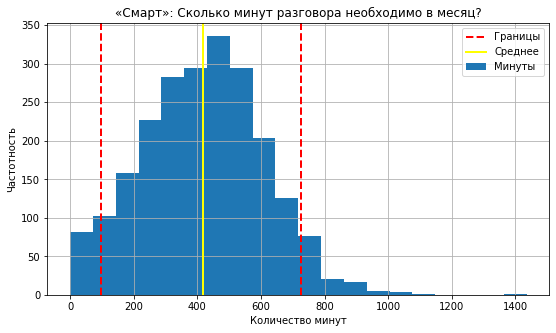

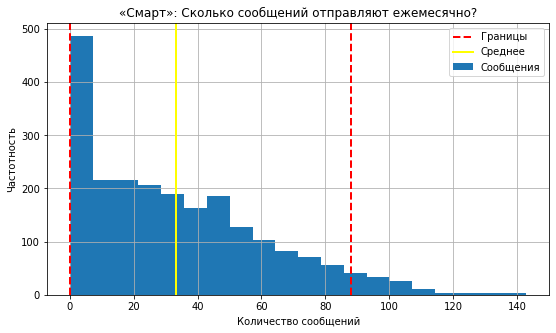

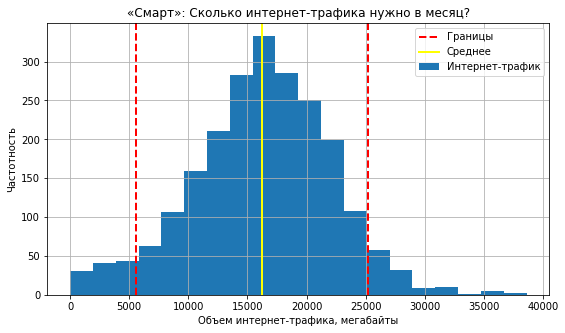

In [91]:
#в переменной сохраним нужные нам для построения графиков столбцы
smart_columns = df_smart[['minutes_sum', 'messages_count', 'mb_used_sum']]
# в legend сохраним словарь с условными обозначениями
legend = {'minutes_sum':'Минуты', 'messages_count':'Сообщения', 'mb_used_sum':'Интернет-трафик'}
# в titles запишем словарь с названиями графиков
titles = {'minutes_sum':'«Смарт»: Сколько минут разговора необходимо в месяц?', 
          'messages_count':'«Смарт»: Сколько сообщений отправляют ежемесячно?', 
          'mb_used_sum':'«Смарт»: Сколько интернет-трафика нужно в месяц?'}
#в labels сохраним подписи осей х
labels = {'minutes_sum':'Количество минут', 'messages_count':'Количество сообщений', 
          'mb_used_sum':'Объем интернет-трафика, мегабайты'}

#создадим цикл, в котором для каждого столбца (column) будет строиться гистрограмма
for column in smart_columns:
    smart_columns[column].plot(kind='hist', bins=20, figsize=(9, 5), label=legend[column], title=titles[column], grid=True)
    #добавим три линии с нижней и верхней границами и средним значением
    plt.axvline(smart_columns[column].quantile(0.05), color='red', linewidth=2, linestyle='--', label='Границы')
    plt.axvline(smart_columns[column].quantile(0.95), color='red', linewidth=2, linestyle='--')
    plt.axvline(smart_columns[column].mean(), color='yellow', linewidth=2, label='Среднее')
    plt.legend()
    plt.xlabel(labels[column])
    plt.ylabel('Частотность')
    plt.show()

Пиковое значение длительности звонков почти совпадает со средним значением (и медианой) и составляет около 430 минут в месяц. Большинство значений попали интервал от нижнего до верхнего порога: 90–730 минут. На графике можно наблюдать небольшую скошенность наборов данных влево.

Пиковое число отправленных за месяц сообщений пришлось на ноль — эти данные не противоречат современным реалиям. С ростом популярности мессенджеров, тарификация которых включена в общий интернет-трафик, платные смс отошли на второй план. Предельные значения для сообщений составляют от 0 до 87, среднее — 33. График показывает на экспоненциальное распределение значений — чем меньше значение числа сообщений, тем меньше частотность.  

Пиковый ежемесячный объем интернет-трафика приходится на среднее значение и равен примерно 16000 мегабайт. Большинство значений входят в интервал от 5500 до 25000 мегабайт. График отображает небольшую скошенность данных влево.

Вычислим разброс этих же значений для тарифа «Ультра»:

In [92]:
#выведем значение дисперсии трех столбцов:
display(np.var(df_ultra[['minutes_sum', 'messages_count', 'mb_used_sum']], ddof=1))

minutes_sum       1.008736e+05
messages_count    2.285266e+03
mb_used_sum       1.019356e+08
dtype: float64

Выведем характерные метрики ежемесячной продолжительности звонков, количества сообщений и объема интернет-трафика:

In [93]:
#используем метод describe()
df_ultra[['minutes_sum', 'messages_count', 'mb_used_sum']].describe()

,minutes_sum,messages_count,mb_used_sum
count,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19486.901523
std,317.606098,47.804457,10096.317202
min,0.000000,0.000000,0.000000
25%,284.000000,6.000000,11785.000000
50%,518.000000,38.000000,19324.000000
75%,752.000000,79.000000,26863.000000
max,1673.000000,224.000000,49789.000000


Средние значения тарифа «Ультра» превышают средние «Смарта». При этом распределение данных двух тарифов схожи.

Средняя ежемесячная длительность звонков составляет 526 минут, медиана немного меньше — 518 минут. Стандартное отклонение равняется 317. Пользователи посылают в среднем 47 сообщений в месяц, это значение приближено к стандартному отклонению (=47) и немного превышает медиану, которая составляет 38 минут. Ежемесячный объем интернет-трафика равен прибл. 19490 мегабайт, медиана расположена очень близко — 19324 мегабайта. Стандартное отклонение составляет 10000 мегабайт. Отметим, что в среднем пользователи не превышают установленных лимитов тарифа «Ультра». Как и в случае с тарифом «Смарт» в столбцах с продолжительностью разговоров и объемом интернет-трафика мы наблюдаем сильный разброс значений. Количество отправленных сообщений, напротив, приближено к среднему.

Построим графики для тарифа «Ультра» и выясним, сколько минут, сообщений и интернет-трафика необходимо пользователям каждый месяц.

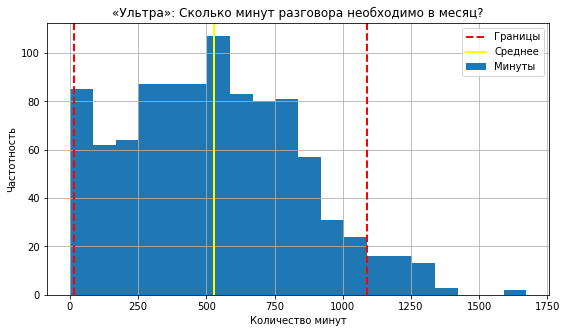

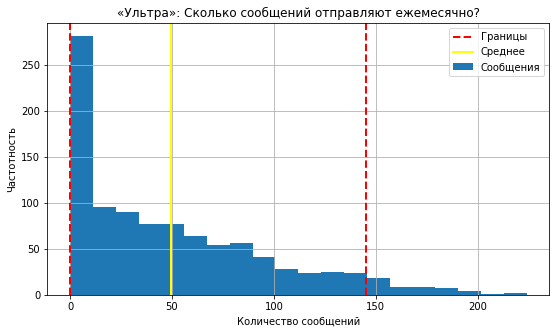

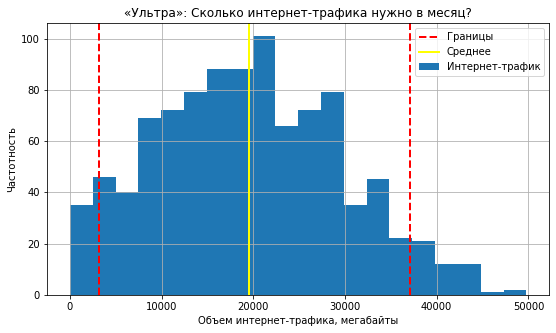

In [94]:
#в переменной сохраним три столбца датасета df_ultra
ultra_columns = df_ultra[['minutes_sum', 'messages_count', 'mb_used_sum']]
#переменные legend и labels такие же, как в предыдущем цикле тарифа "Смарт"
#зададим новые названия графиков
titles = {'minutes_sum':'«Ультра»: Сколько минут разговора необходимо в месяц?', 
          'messages_count':'«Ультра»: Сколько сообщений отправляют ежемесячно?', 
          'mb_used_sum':'«Ультра»: Сколько интернет-трафика нужно в месяц?'}

#создадим цикл для построения гистрограмм, снова отметим на графике линии со средним и нижней и верхней границами
for column in ultra_columns:
    ultra_columns[column].plot(kind='hist', bins=20, figsize=(9, 5), label=legend[column], title=titles[column], grid=True)
    plt.axvline(ultra_columns[column].quantile(0.05), color='red', linewidth=2, linestyle='--', label='Границы')
    plt.axvline(ultra_columns[column].quantile(0.95), color='red', linewidth=2, linestyle='--')
    plt.axvline(ultra_columns[column].mean(), color='yellow', linewidth=2, label='Среднее')
    plt.legend()
    plt.xlabel(labels[column])
    plt.ylabel('Частотность')
    plt.show()

Чаще всего продолжительсть звонков в месяц в тарифе «Ультра» составляет около 500 минут, что близко по значению к среднему. Большинство значений входит в предел от 20 до 1100 минут. График для длительности звонков ассиметричен, имеет положительную скошенность.

Пиковое значение отправленных за месяц сообщений такое же, как в тарифе «Смарт», — равно нулю. Этот график также указывает на экспоненциальное распределение данных. Граничные значения составляют от 0 до 145 сообщений в месяц. 

Ежемесячный пиковый объем интернет-трафика равен 20000 мегабайт и близок по значению к среднему. Нижняя граница равна 3000 мегабайт, верхняя — 37000. График тоже ассиметричный, наблюдается скошенность данных вправо. 

**Вывод**

Мы проанализировали поведение клиентов каждого из тарифов и можем прийти к выводу, что в среднем продолжительность телефонных звонков варьируется от 7 до 8,5 часов в месяц: прибл. 430 минут для тарифа «Смарт» и 500 — для «Ультра». 
<br>Чаще всего пользователи обоих тарифов вообще не отправляют сообщения, пиковые значения равны нулю. Мы это объясняем популярностью мессенджеров: отправка сообщений в них не тарифицируется, считаются только потраченные мегабайты. Средние значения числа сообщений в месяц составляют 49 смс в тарифе «Ультра» и 33 — в тарифе «Смарт». 
<br>Средний ежемесячный объем интернет-трафика в тарифе «Смарт» меньше, чем в «Ультра». В тарифе «Смарт» среднее (и одновременно пиковое) значение составляет примерно 16 Гб, в тарифе «Ультра» — среднее равно 19–20 Гб. 

## Проверка гипотез

Проанализируем ежемесячную выручку «Мегалайна» с пользователей. Нам нужно выяснить, есть ли различия между средними значениями выручки двух тарифов ««Ультра» и «Смарт». А также есть ли существенная разница между средней выручкой пользователей из Москвы по сравнению с другими регионами. 

Вычислим общую выручку «Мегалайна» за 2018 год в нашей выборке:

In [95]:
#применим метод sum() ко всему столбцу revenue
print('Общая выручка «Мегалайна» данной выборки составила', df['revenue'].sum(), 'рублей')

Общая выручка «Мегалайна» данной выборки составила 4779476.0 рублей


Выручка с пользователей за год составила почти 5 млн рублей. Построим график, чтобы выяснить, какую долю от общей выручки принесли пользователи каждого из тарифов:

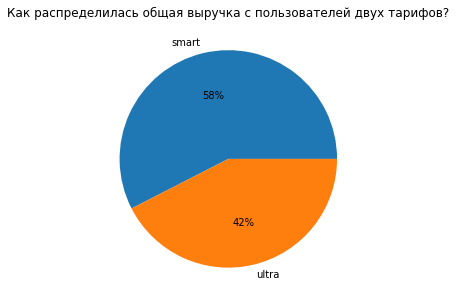

In [96]:
#сгруппируем данные по тарифу и выведем процентные доли от общей выручки:
df.groupby('tariff')['revenue'].sum().plot(kind='pie', title='Как распределилась общая выручка с пользователей двух тарифов?',
                                          figsize=(9, 5), autopct='%1.0f%%')
plt.ylabel('')
plt.show()

Суммарная выручка пользователей «Смарт» составляет чуть большую долю. Сформулируем гипотезу и выясним, различается ли средняя выручка пользователей двух тарифов: 
<br>**Нулевая гипотеза**: средние значения выручки пользователей двух тарифов «Ультра» и «Смарт» одинаковы.
<br>**Альтернативная гипотеза**: средние значения различаются.

Вычислим дисперсию для значений ежемесячной выручки пользователей «Ультра» и «Смарт» и посчитаем стандартное отклонение:

In [97]:
#применим метод var() для вычисления дисперсии, std() – для стандартного отклонения
#укажем параметр ddof=1, так как мы работаем с выборкой
print('Дисперсия выручки, «Смарт»:', np.var(df_smart['revenue'], ddof=1))
print('Стандартное отклонение выручки, «Смарт»:', np.std(df_smart['revenue'], ddof=1))
print('Дисперсия выручки, «Ультра»:', np.var(df_ultra['revenue'], ddof=1))
print('Стандартное отклонение выручки, «Ультра»:', np.std(df_ultra['revenue'], ddof=1))

Дисперсия выручки, «Смарт»: 620699.7337862339
Стандартное отклонение выручки, «Смарт»: 787.8449935020428
Дисперсия выручки, «Ультра»: 127060.63069002518
Стандартное отклонение выручки, «Ультра»: 356.45565038308087


Дисперсия выручки и, следовательно, стандартное отклонение в тарифе «Смарт» гораздо больше, чем в «Ультра». То есть в выручке по «Смарт» значения разбросаны относительно среднего сильнее, чем в «Ультра».

Построим графики, чтобы посмотреть на распределение значений выручки: 

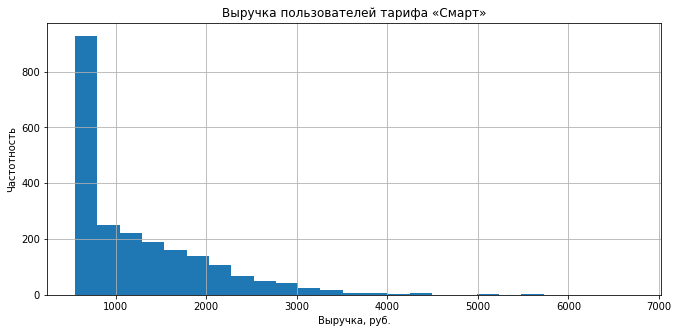

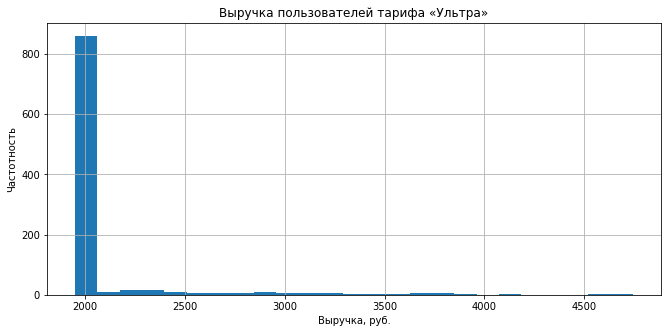

In [98]:
#построим гистограмму для выручки тарифа "Смарт"
df_smart['revenue'].plot(kind='hist', bins=25, figsize=(11, 5), 
                         title='Выручка пользователей тарифа «Смарт»', grid=True)
plt.xlabel('Выручка, руб.')
plt.ylabel('Частотность')
plt.show()

#создадим аналогичный график для выручки тарифа "Ультра"
df_ultra['revenue'].plot(kind='hist', bins=25, figsize=(11, 5), 
                         title='Выручка пользователей тарифа «Ультра»', grid=True)
plt.xlabel('Выручка, руб.')
plt.ylabel('Частотность')
plt.show()

Пиковые значения на обоих графиках приходятся на стоимость абонентской платы: 550 рублей для «Смарт» и 1950 для «Ультра». Распределение экспоненциальное, при этом пользователи «Ультра» очень редко переплачивают за превышение тарифного лимита. Пользователи «Смарт», напротив, зачастую покупают дополнительные пакеты услуг.

Для проверки нулевой гипотезы проведем t-тест для значений ежемесячной выручки выборок по тарифу и вычислим p-value. Критический уровень статистической значимости *alpha* установим в 5 %. В параметре *equal_var* укажем *False*, чтобы не допустить серьезную ошибку в расчетах: у нас нет оснований считать, что дисперсии наших двух выборок хотя бы приблизительно равны.

In [99]:
alpha = 0.05
#в переменной tarif_result сохраним результаты метода scipy.stats.ttest_ind:
#в первом массиве укажем выборку "Смарт", во втором — "Ультра"
tarif_result = st.ttest_ind(df_smart['revenue'], df_ultra['revenue'], equal_var = False)
#выведем значение p-value
print('Значение p-value:', tarif_result.pvalue)

#зададим условие: если p-value меньше порогового значения, то мы отвергаем нулевую гипотезу
if tarif_result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, средние значения выручки различаются')
#в противном случае мы не отвергаем нулевую гипотезу
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение p-value: 1.620572799195892e-295
Отвергаем нулевую гипотезу, средние значения выручки различаются


Значение p-value очень близко нулю, а значит меньше порогового значения *alpha*. Мы можем отвергнуть гипотезу о том, что средние выручки пользователей двух тарифов совокупности не различаются. 

Проверим, есть ли различия между средней выручкой пользователей Москвы и клиентов из других регионов. Сформулируем гипотезы:
<br>**Нулевая гипотеза**: средние значения выручки пользователей в Москве и в других регионах равны. 
<br>**Альтернативная гипотеза**: средние значения выручки различаются.

Для начала создадим новый столбец, в котором распределим все города из столбца *city* на «Москву» и «Другой регион»:

In [100]:
#напишем функцию, которая принимает строку с названием города и распределяет значения на Москву и Другой регион
def city(row):
    if 'Москва' in row:
        return 'Москва'
    return 'Другой регион'

#применим функцию city к столбцу df['city'] и создадим новый столбец region
df['region'] = df['city'].apply(city)
#выведем на экран 10 случайных строк столбцов city и region
df[['city', 'region']].sample(10)

,city,region
1758,Ульяновск,Другой регион
3039,Набережные Челны,Другой регион
1300,Москва,Москва
2229,Ставрополь,Другой регион
2524,Пенза,Другой регион
173,Мурманск,Другой регион
898,Тюмень,Другой регион
2926,Ижевск,Другой регион
342,Казань,Другой регион
804,Казань,Другой регион


Теперь мы можем разбить нашу таблицу на две: в одной будут все пользователи из Москвы, во второй — все клиенты из других регионов:

In [101]:
#таблица с клиентами из Москвы
moscow = df[df['region'] == 'Москва']
#таблица с клиентами из регионов
regions = df[df['region'] == 'Другой регион']

Посчитаем дисперсию и стандартное отклонение для выручки из Москвы и регионов:

In [102]:
#используем методы var и std, работаем с выборкой, поэтому указываем параметр ddof=1
print('Дисперсия выручки, Москва:', np.var(moscow['revenue'], ddof=1))
print('Стандартное отклонение выручки, Москва:', np.std(moscow['revenue'], ddof=1))
print('Дисперсия выручки, регионы:', np.var(regions['revenue'], ddof=1))
print('Стандартное отклонение выручки, регионы:', np.std(regions['revenue'], ddof=1))

Дисперсия выручки, Москва: 547324.220605833
Стандартное отклонение выручки, Москва: 739.8136391050336
Дисперсия выручки, регионы: 630640.4847304136
Стандартное отклонение выручки, регионы: 794.1287582819386


Значения стандартного отклонения выручки пользователей из Москвы и из других регионов близки: то есть данные одинаково разбросаны вокруг среднего. Посмотрим на графиках, как распределилась выручка: 

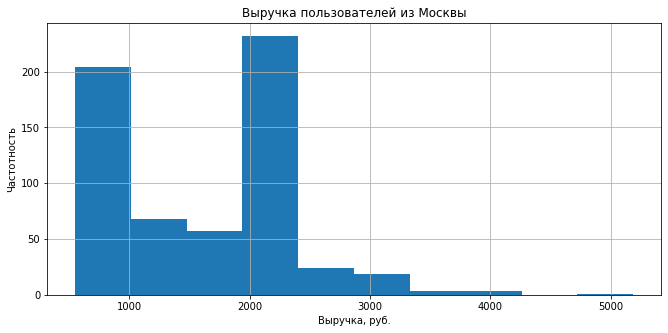

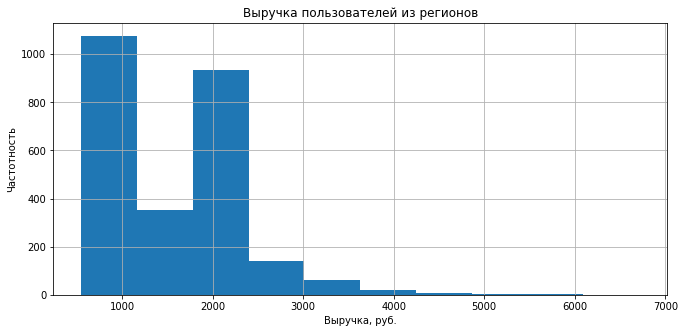

In [103]:
#строим гистограмму для выручки с клиентов из Москвы
moscow['revenue'].plot(kind='hist', figsize=(11, 5), title='Выручка пользователей из Москвы', grid=True)
plt.xlabel('Выручка, руб.')
plt.ylabel('Частотность')
plt.show()

#создадим аналогичный график для пользователей из других регионов
regions['revenue'].plot(kind='hist', figsize=(11, 5), title='Выручка пользователей из регионов', grid=True)
plt.xlabel('Выручка, руб.')
plt.ylabel('Частотность')
plt.show()

Заметим, что пиковые значения приходятся на стоимость абоненской платы: 550 (тариф «Смарт») и 1950 («Ультра») рублей для каждого из тарифов. Причем в Москве число пользователей тарифа «Ультра» с более высокой ежемесячной стоимостью немного превышает количество клиентов с тарифом «Смарт». В других регионах ситуация обратная: число клиентов, которые подключили «Смарт», выше чем у «Ультра». 

Проверим нулевую гипотезу и выясним, есть ли разница между средними значениями выручки пользователей из Москвы и регионов:

In [104]:
#пороговое значение 5 %
alpha = 0.05
#снова используем метод scipy.stats.ttest_ind
#первый массив - клиенты из Москвы, второй - из регионов
#снова укажем параметр equal_var = False
region_result = st.ttest_ind(moscow['revenue'], regions['revenue'], equal_var = False)
print('Значение p-value равно:', region_result.pvalue)

#если p-value меньше порогового значения, отвергаем гипотезу
if region_result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние выручки пользователей Москвы и регионов различаются')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение p-value равно: 0.4553974892423337
Не получилось отвергнуть нулевую гипотезу


P-value составляет почти 50 %, значит мы не отвергаем нулевую гипотезу. Можем сделать предположение, что средние значения выручки клиентов «Мегалайна» из Москвы и из других регионов в генеральной совокупности не различаются. 

**Вывод**

Мы проверили две гипотезы и пришли к выводу, что, средняя выручка пользователей двух тарифов «Смарт» и «Ультра» в генеральной совокупности, по всей видимости, различается. Также мы предположили, что значения средней выручки пользователей из Москвы и регионов в генеральной совокупности не различаются. Но так как мы проводили анализ *выборки*, точно подтвердить эти утверждения мы не можем.

## Общий вывод

Перед нами стояла задача выяснить, какой из двух тарифов «Мегалайна» приносит больше денег: «Ультра» или «Смарт». Мы работали с небольшой выборкой, состоящей 500 клиентов и общей информацией об их поведении. В ходе исследования мы установили, что пиковое значение ежемесячной продолжительности звонков и объема интернет-трафика для обоих тарифов приходится на среднее значение. Пользователи также одинаково мало пишут сообщения — чаще всего в течение месяца не отправляют ни одного. 
<br> Если оценивать выручку с каждого тарифа, можно сделать вывод, что чаще всего пользователи оплачивают абонентскую плату и, по всей видимости, стараются уложиться в установленные лимиты. При этом клиентам «Смарт» приходится переплачивать за дополнительные пакеты гораздо чаще, чем клиентам «Ультра». Также нам не удалось подтвердить гипотезу о том, что средняя выручка с двух тарифов одинаковая.<br> Жители Москвы чаще подключаются к «Ультра», а в регионах ситуация обратная: количество пользователей тарифа «Смарт» немного больше. По результатам t-теста мы не отвергнули гипотезу о том, что средние значения выручки клиентов из Москвы и из других регионов равны.

Общая выручка по этой выборке составила 4,7 млн рублей. Из них 58 % выручки пришлось на тариф «Смарт», 42 % — на «Ультра». Исходя из всех описанных выше выводов, можно сказать, что тариф «Смарт» приносит больше доходов.